<a href="https://colab.research.google.com/github/ericyoc/adversarial-defense-cnn/blob/main/cnn_attack_defense_all_digit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Convolutional Neural Network (CNN) Model Using either MNIST or EMNIST Datasets with Protection Using Adverarial Training Against Compounded Attacks

Make sure to set runtime to GPU (e.g., T4 GPU - Google Colabs) instead of CPU

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Assumes that datasets are on Google Drive and that Google Drive will be mounted with default directory structure

Compounded attack: fgsm_cw attack, fgsm_pgd attack, cw_pgd_attack, Dataset: MNIST, EMNIST 'Digits'

ATTENTION: MUST INSTALL AT A MINIMUM FOLLOWING FOR PYTHON CODE TO WORK CORRECTLY

Python version: 3.8.18
torch: 2.2.1
torchvision: 0.17.1
torchattacks: 3.5.1
numpy: 1.23.5
tabulate: 0.9.0

In [ ]:
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

In [ ]:
#!pip install torchattacks
import torchattacks

In [ ]:
#Pick a compounded adversarial attack from the following: fgsm_cw_attack, fgsm_pgd_attack, cw_pgd_attack
global compounded_attack_name

compounded_attack_name = "fgsm_pgd_attack"

In [ ]:
# Set the dataset_name
global dataset_name
dataset_name = 'EMNIST'  # 'MNIST' or 'EMNIST' or 'SVHN' or 'USPS' or 'Semeion'

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Access the mounted drive
drive_path = '/content/drive/My Drive/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
global num_epochs
num_epochs = 10

In [ ]:
import sys
import pkg_resources

def get_package_versions(package_list):
    installed_packages = pkg_resources.working_set
    package_versions = {}

    for package_name in package_list:
        package = installed_packages.by_key.get(package_name)
        if package:
            package_versions[package_name] = package.version
        else:
            package_versions[package_name] = "Not installed"

    return package_versions

# Specify the list of packages you want to check
packages_to_check = ["torch", "torchvision", "torchattacks", "torchvision", "numpy", "tabulate"]

# Call the function to get package versions
versions = get_package_versions(packages_to_check)

In [ ]:
# Get the Python version
python_version = sys.version.split()[0]

# Call the function to get package versions
versions = get_package_versions(packages_to_check)

# Print the Python version
print(f"Python version: {python_version}")

# Print the package versions
for package_name, version in versions.items():
    print(f"{package_name}: {version}")

Python version: 3.10.12
torch: 2.2.1+cu121
torchvision: 0.17.1+cu121
torchattacks: 3.5.1
numpy: 1.25.2
tabulate: 0.9.0


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
# Define model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, 5)
        self.conv2 = nn.Conv2d(4, 10, 5)
        self.fc1 = nn.Linear(160, 80)
        self.fc2 = nn.Linear(80, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 160)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = CNN().to(device)

print("Model Architecture:")
print(model)

Model Architecture:
CNN(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=160, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=10, bias=True)
)


In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
loss_fn = nn.NLLLoss()

In [ ]:
import gzip
import numpy as np
from torchvision import transforms

def load_emnist_digits(data_dir, train=True, transform=None, filtered=range(10)):
    if train:
        image_file = 'emnist-digits-train-images-idx3-ubyte.gz'
        label_file = 'emnist-digits-train-labels-idx1-ubyte.gz'
    else:
        image_file = 'emnist-digits-test-images-idx3-ubyte.gz'
        label_file = 'emnist-digits-test-labels-idx1-ubyte.gz'

    image_path = os.path.join(data_dir, image_file)
    label_path = os.path.join(data_dir, label_file)

    with gzip.open(image_path, 'rb') as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)
    with gzip.open(label_path, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)

    dataset = EMNISTDataset(images, labels, transform)

    if filtered is not None:
        digits_to_keep = list(filtered)  # Convert the range object to a list
        mask = np.isin(dataset.labels, digits_to_keep)
        dataset.images = dataset.images[mask]
        dataset.labels = dataset.labels[mask]

    return dataset

In [ ]:
def filtered_dataset_EMNIST(train_set, test_set, filtered_digits=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
    if filtered_digits is not None:
        train_mask = np.isin(train_set.labels, filtered_digits)
        test_mask = np.isin(test_set.labels, filtered_digits)

        train_images = train_set.images[train_mask]
        train_labels = train_set.labels[train_mask]
        test_images = test_set.images[test_mask]
        test_labels = test_set.labels[test_mask]

        filtered_train_set = EMNISTDataset(train_images, train_labels, transform=train_set.transform)
        filtered_test_set = EMNISTDataset(test_images, test_labels, transform=test_set.transform)
    else:
        filtered_train_set = train_set
        filtered_test_set = test_set

    return filtered_train_set, filtered_test_set

In [ ]:
import gzip
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

class EMNISTDigits(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None):
        self.root = root
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

        prefix = 'train' if self.train else 'test'
        image_file = f'{self.root}/emnist-digits-{prefix}-images-idx3-ubyte.gz'
        label_file = f'{self.root}/emnist-digits-{prefix}-labels-idx1-ubyte.gz'

        with gzip.open(image_file, 'rb') as f:
            self.images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

        with gzip.open(label_file, 'rb') as f:
            self.labels = np.frombuffer(f.read(), np.uint8, offset=8)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return image, label

    def __len__(self):
        return len(self.images)

In [ ]:
!ls "/content/drive/My Drive/data/EMNIST/raw/"

emnist-digits-test-images-idx3-ubyte.gz  emnist-digits-train-images-idx3-ubyte.gz
emnist-digits-test-labels-idx1-ubyte.gz  emnist-digits-train-labels-idx1-ubyte.gz


In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

if dataset_name == 'MNIST':
    # Load a dataset from Google Drive
    data_dir = drive_path + 'data/MNIST/'
    print(data_dir)
    train_set = datasets.MNIST(data_dir, train=True, download=False, transform=transforms.ToTensor())
    test_set = datasets.MNIST(data_dir, train=False, download=False, transform=transforms.ToTensor())
elif dataset_name == 'EMNIST':
    # Load a dataset from Google Drive
    data_dir = drive_path + 'data/EMNIST/raw/'
    train_set = EMNISTDigits(data_dir, train=True, transform=ToTensor())
    test_set = EMNISTDigits(data_dir, train=False, transform=ToTensor())
    print(data_dir)
elif dataset_name == 'SVHN':
    data_dir = '/content/drive/data/'
    train_set = datasets.SVHN(data_dir, split='train', download=True, transform=data_transform)
    test_set = datasets.SVHN(data_dir, split='test', download=True, transform=data_transform)
elif dataset_name == 'USPS':
    data_dir = '/content/drive/data/'
    train_set = datasets.USPS(data_dir, train=True, download=True, transform=data_transform)
    test_set = datasets.USPS(data_dir, train=False, download=True, transform=data_transform)
elif dataset_name == 'Semeion':
    data_dir = '/content/drive/data/'
    from torch.utils.data import DataLoader, Dataset, random_split
    import numpy as np
    from torchvision import transforms

    class SemeionDataset(Dataset):
        def __init__(self, file_path, transform=None):
            data = np.loadtxt(file_path)
            self.images = data[:, :256].reshape(-1, 16, 16).astype(np.float32)
            self.labels = data[:, 256:].astype(np.int64)
            self.transform = transform

        def __len__(self):
            return len(self.images)

        def __getitem__(self, idx):
            image = self.images[idx]
            label = self.labels[idx].argmax()  # Convert one-hot encoded labels to integers
            if self.transform:
                image = self.transform(image)
            return image, label

    # Define the data transformation
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((28, 28)),  # Resize the images to 28x28 pixels
        transforms.Normalize((0.1307,), (0.3081,))  # Normalize the images
    ])

    # Load the Semeion dataset
    dataset = SemeionDataset(data_dir, transform=data_transform)

    # Split the dataset into training and test sets
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_set, test_set = random_split(dataset, [train_size, test_size])

else:
    raise ValueError("Invalid dataset name.")

/content/drive/My Drive/data/EMNIST/raw/


In [ ]:
#from torchvision import datasets, transforms
#from torch.utils.data import DataLoader, Subset, random_split
from torch.utils.data import Subset
import numpy as np

def filtered_dataset(train_set, test_set, filtered=0, dataset_name=None):
    if filtered == 0:  # digits 0 and 1
        if dataset_name == 'SVHN' or dataset_name == 'EMNIST':
            train_indexes_0 = torch.where(torch.tensor(train_set.labels) == 0)[0]
            train_indexes_1 = torch.where(torch.tensor(train_set.labels) == 1)[0]
            test_indexes_0 = torch.where(torch.tensor(test_set.labels) == 0)[0]
            test_indexes_1 = torch.where(torch.tensor(test_set.labels) == 1)[0]
        elif dataset_name == 'USPS':
            train_indexes_0 = torch.where(torch.tensor(train_set.targets) == 0)[0]
            train_indexes_1 = torch.where(torch.tensor(train_set.targets) == 1)[0]
            test_indexes_0 = torch.where(torch.tensor(test_set.targets) == 0)[0]
            test_indexes_1 = torch.where(torch.tensor(test_set.targets) == 1)[0]
        else:
            try:
                train_indexes_0 = torch.where(train_set.targets == 0)[0]
                train_indexes_1 = torch.where(train_set.targets == 1)[0]
                test_indexes_0 = torch.where(test_set.targets == 0)[0]
                test_indexes_1 = torch.where(test_set.targets == 1)[0]
            except AttributeError:
                train_indexes_0 = torch.where(torch.tensor(train_set.labels) == 0)[0]
                train_indexes_1 = torch.where(torch.tensor(train_set.labels) == 1)[0]
                test_indexes_0 = torch.where(torch.tensor(test_set.labels) == 0)[0]
                test_indexes_1 = torch.where(torch.tensor(test_set.labels) == 1)[0]

        num_to_sample_train = min(len(train_indexes_0), len(train_indexes_1))
        num_to_sample_test = min(len(test_indexes_0), len(test_indexes_1))

        sampled_train_indexes_0 = train_indexes_0[torch.randperm(len(train_indexes_0))[:num_to_sample_train]]
        sampled_train_indexes_1 = train_indexes_1[torch.randperm(len(train_indexes_1))[:num_to_sample_train]]
        sampled_test_indexes_0 = test_indexes_0[torch.randperm(len(test_indexes_0))[:num_to_sample_test]]
        sampled_test_indexes_1 = test_indexes_1[torch.randperm(len(test_indexes_1))[:num_to_sample_test]]

        selected_train_indexes = torch.cat([sampled_train_indexes_0, sampled_train_indexes_1])
        selected_test_indexes = torch.cat([sampled_test_indexes_0, sampled_test_indexes_1])

    elif filtered == 1:  # digits 0 to 9
        train_indexes = []
        test_indexes = []
        for i in range(10):
            if dataset_name == 'SVHN' or dataset_name == 'EMNIST':
                train_idx = torch.where(torch.tensor(train_set.labels) == i)[0]
                test_idx = torch.where(torch.tensor(test_set.labels) == i)[0]
            elif dataset_name == 'USPS':
                train_idx = torch.where(torch.tensor(train_set.targets) == i)[0]
                test_idx = torch.where(torch.tensor(test_set.targets) == i)[0]
            elif dataset_name == 'Semeion':
                train_idx = torch.tensor([dataset.labels[idx].argmax() for idx in train_set.indices])
                test_idx = torch.tensor([dataset.labels[idx].argmax() for idx in test_set.indices])
            else:
                try:
                    train_idx = torch.where(train_set.targets == i)[0]
                    test_idx = torch.where(test_set.targets == i)[0]
                except AttributeError:
                    train_idx = torch.where(torch.tensor(train_set.labels) == i)[0]
                    test_idx = torch.where(torch.tensor(test_set.labels) == i)[0]

            train_indexes.append(train_idx)
            test_indexes.append(test_idx)

        min_num_samples_train = min(len(idx) for idx in train_indexes)
        min_num_samples_test = min(len(idx) for idx in test_indexes)

        sampled_train_indexes = []
        sampled_test_indexes = []
        for train_idx, test_idx in zip(train_indexes, test_indexes):
            sampled_train_indexes.append(train_idx[torch.randperm(len(train_idx))[:min_num_samples_train]])
            sampled_test_indexes.append(test_idx[torch.randperm(len(test_idx))[:min_num_samples_test]])

        selected_train_indexes = torch.cat(sampled_train_indexes)
        selected_test_indexes = torch.cat(sampled_test_indexes)

    else:
        raise ValueError("Invalid value for 'filtered'. Choose either 0 or 1.")

    filtered_train_set = torch.utils.data.Subset(train_set, selected_train_indexes)
    filtered_test_set = torch.utils.data.Subset(test_set, selected_test_indexes)

    return filtered_train_set, filtered_test_set

In [ ]:
global filtered_train_set, filtered_test_set
print(dataset_name)
#if dataset_name == "EMNIST":
  #filtered_train_set, filtered_test_set = filtered_dataset_EMNIST(train_set, test_set)
#else:
filtered_train_set, filtered_test_set = filtered_dataset(train_set, test_set, filtered=1)

EMNIST


In [ ]:
global filtered_train_loader, filtered_test_loader

filtered_train_loader = DataLoader(filtered_train_set, batch_size=64, shuffle=True)
filtered_test_loader = DataLoader(filtered_test_set, batch_size=64)

print(len(filtered_train_loader))
print(len(filtered_test_loader))

3750
625


In [ ]:
import matplotlib.pyplot as plt
def print_images(images, labels, preds, n):

    fig = plt.figure(figsize=(6, 6))
    for i in range(n):
        ax = fig.add_subplot(2, 3, i+1)
        img = images[i].squeeze()
        ax.imshow(img, cmap='gray')
        pred = preds[i].argmax()
        ax.set_title(f"{labels[i].item()} -> {pred.item()}")
        ax.axis('off')

    plt.show()

In [ ]:
import os

def save_clean_model(model, save_dir):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    model_path = f"{save_dir}/clean_model.pth"

    torch.save(model.state_dict(), model_path)
    #print(f"Saved clean_model state dict to {model_path}")

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy_loss(train_accuracies, train_losses):
    epochs = range(1, len(train_accuracies) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Train model
import numpy as np
import torch

def train_model(model, train_loader, loss_fn, optimizer, num_epochs, device, batch_size=128, learning_rate=0.001, weight_decay=0.0001):
    # Model folder
    save_dir = 'clean_models'

    train_accuracies = []
    train_losses = []

    model.to(device)  # Move the model to the specified device

    # Adjust learning rate and weight decay
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
        param_group['weight_decay'] = weight_decay

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for i, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)  # Move input data to the specified device

            preds = model(imgs)
            loss = loss_fn(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(preds.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            if i == 0:
                print_images(imgs.cpu(), labels.cpu(), preds.cpu(), n=3)  # Move data back to CPU for printing

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

        train_accuracies.append(train_acc)
        train_losses.append(train_loss)

    # Plot accuracy and loss curves
    plot_accuracy_loss(train_accuracies, train_losses)

    save_clean_model(model, save_dir)

Epoch 1/10


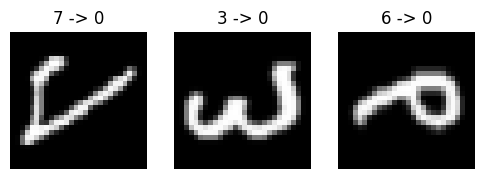

Train Loss: 0.1415, Train Accuracy: 0.9579
Epoch 2/10


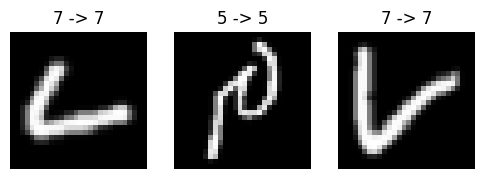

Train Loss: 0.0497, Train Accuracy: 0.9850
Epoch 3/10


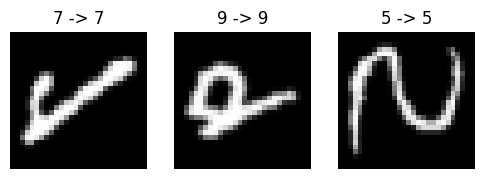

Train Loss: 0.0387, Train Accuracy: 0.9883
Epoch 4/10


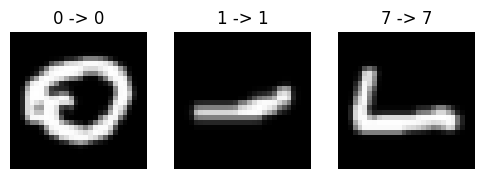

Train Loss: 0.0332, Train Accuracy: 0.9901
Epoch 5/10


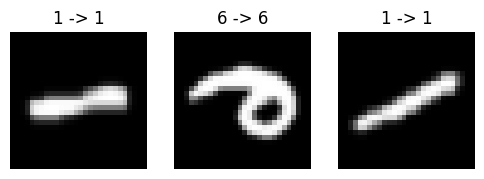

Train Loss: 0.0293, Train Accuracy: 0.9914
Epoch 6/10


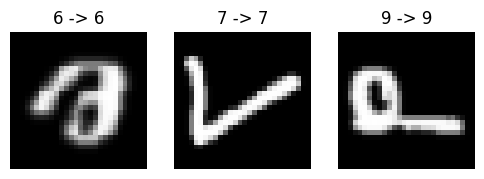

Train Loss: 0.0264, Train Accuracy: 0.9921
Epoch 7/10


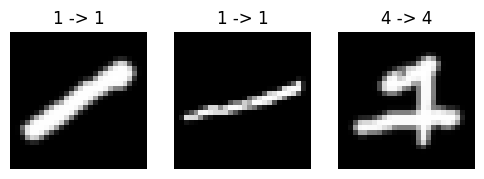

Train Loss: 0.0248, Train Accuracy: 0.9926
Epoch 8/10


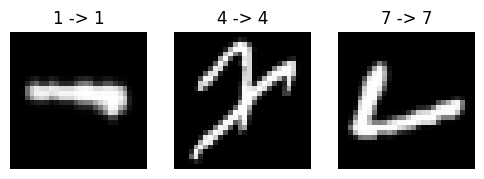

Train Loss: 0.0235, Train Accuracy: 0.9929
Epoch 9/10


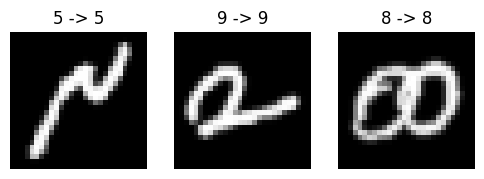

Train Loss: 0.0222, Train Accuracy: 0.9933
Epoch 10/10


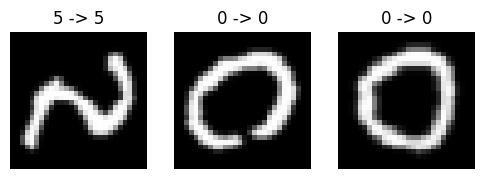

Train Loss: 0.0211, Train Accuracy: 0.9937


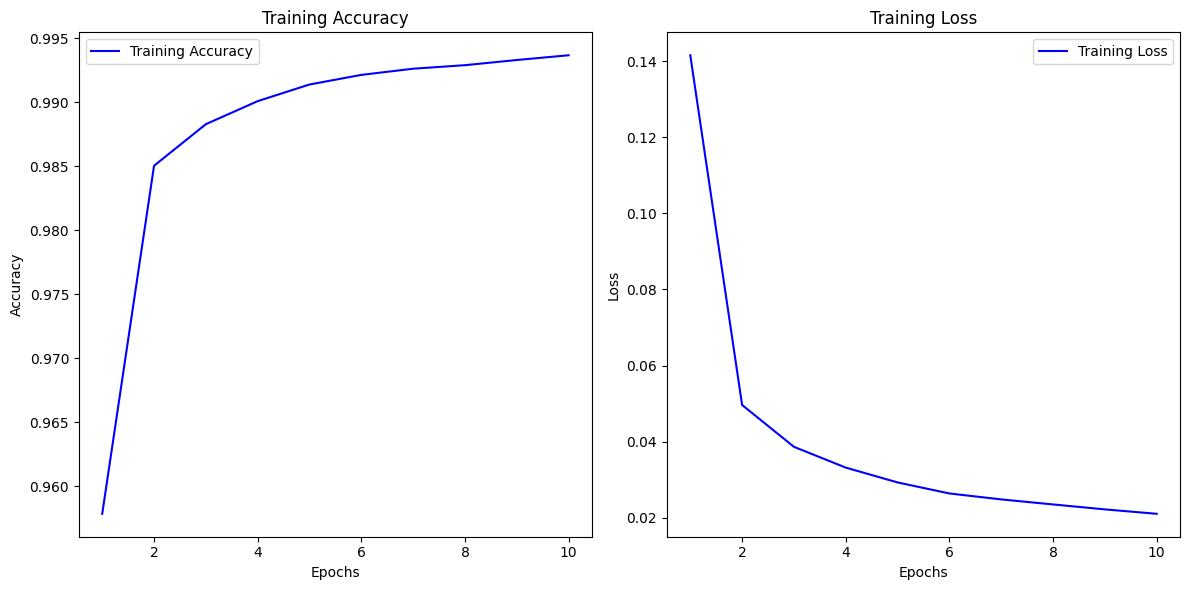

In [ ]:
import time
# Start the timer
start_time = time.time()
train_model(model, filtered_train_loader, loss_fn, optimizer, num_epochs,device)
# End the timer
end_time = time.time()

In [ ]:

# Calculate the training duration in seconds
training_duration_seconds = abs(end_time - start_time)

# Calculate the training duration in minutes
training_duration_minutes = training_duration_seconds / 60

# Calculate the training duration in hours
training_duration_hours = training_duration_minutes / 60

# Print the training duration in different units
print(f"Training duration: {training_duration_seconds:.2f} seconds")
print(f"Training duration: {training_duration_minutes:.2f} minutes")
print(f"Training duration: {training_duration_hours:.2f} hours")

Training duration: 199.81 seconds
Training duration: 3.33 minutes
Training duration: 0.06 hours


In [ ]:
def load_clean_model(model, save_dir):
    # Model folder
    model_path = f"{save_dir}/clean_model.pth"

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found in {model_path}")

    model.load_state_dict(torch.load(model_path))
    model.eval()

    print(f"Loaded clean_model state dict from {model_path}")
    return model

In [ ]:
images, labels = next(iter(filtered_train_loader))
num_clean_elements = len(images)
print(f"Number of clean images: {num_clean_elements}")

Number of clean images: 64


In [ ]:
import matplotlib.pyplot as plt

def plot_test_accuracy_loss(test_accuracy, test_loss):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(1, test_accuracy, color='r', label='Testing Accuracy')
    plt.title('Testing Accuracy')
    plt.xlabel('Evaluation')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.bar(1, test_loss, color='r', label='Testing Loss')
    plt.title('Testing Loss')
    plt.xlabel('Evaluation')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate(model, data_loader, loss_fn, device):
    test_loss = 0.0
    test_accuracy = 0.0
    num_misclassified = 0
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)  # Move data to the specified device
    num_clean_test_elements = len(images)
    print(f"Number of clean test images: {num_clean_test_elements}")

    # Create dataset
    test_ds = TensorDataset(images, labels)
    # Create loader
    test_loader = DataLoader(test_ds, batch_size=64)
    dataset_size = len(test_loader.dataset)

    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)  # Move data to the specified device
            logits = model(x)
            batch_loss = loss_fn(logits, y)
            test_loss += batch_loss.item()
            preds = torch.argmax(logits, dim=1)
            test_accuracy += torch.sum(preds == y).item() / len(y)
            incorrect_inds = torch.where(preds != y)[0]
            num_misclassified += len(incorrect_inds)
            if len(incorrect_inds) > 0:
                misclassified_images.append(x[incorrect_inds].cpu())  # Move data back to CPU
                misclassified_labels.append(y[incorrect_inds].cpu())  # Move data back to CPU
                misclassified_preds.append(preds[incorrect_inds].cpu())  # Move data back to CPU

    num_misclassified = min(num_misclassified, dataset_size)
    print(f"Number of misclassified images: {num_misclassified} out of {dataset_size}")
    test_loss /= len(test_loader)
    test_accuracy /= len(test_loader)
    print(f"Clean Test loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2%}")

    # Plot the test accuracy and loss
    #plot_test_accuracy_loss(test_accuracy, test_loss)

    # Handle empty lists
    if len(misclassified_images) == 0:
        misclassified_images.append(torch.tensor([]))
    if len(misclassified_labels) == 0:
        misclassified_labels.append(torch.tensor([]))
    if len(misclassified_preds) == 0:
        misclassified_preds.append(torch.tensor([]))

    return test_loss, test_accuracy, [torch.cat(misclassified_images)], [torch.cat(misclassified_labels)], [torch.cat(misclassified_preds)]

In [ ]:
# Model folder
save_dir = 'clean_models'

# Loading
clean_model = load_clean_model(CNN().to(device), save_dir)

Loaded clean_model state dict from clean_models/clean_model.pth


In [ ]:
from torch.utils.data import TensorDataset
# Evaluation
#test_loss, test_acc = evaluate(clean_model, filtered_test_loader, loss_fn)
test_loss, test_acc, misclassified_images, misclassified_labels, misclassified_preds = evaluate(clean_model, filtered_test_loader, loss_fn, device)

Number of clean test images: 64
Number of misclassified images: 0 out of 64
Clean Test loss: 0.0014, Accuracy: 100.00%


In [ ]:
import math
def analyze_for_misclassifications(misclassified_images, misclassified_labels, misclassified_preds):

    MAX_IMAGES = 60

    if len(misclassified_images) > 0:
        misclassified_images = misclassified_images[0]
        misclassified_labels = misclassified_labels[0]
        misclassified_preds = misclassified_preds[0]

        print(f"Number misclassified: {len(misclassified_images)}")

        # Truncate more than MAX_IMAGES
        images = misclassified_images[:MAX_IMAGES]
        labels = misclassified_labels[:MAX_IMAGES]
        preds = misclassified_preds[:MAX_IMAGES]


        num_images = len(images)

        fig = plt.figure(figsize=(6, num_images))

        rows = math.ceil(num_images / 2)
        cols = 2 if num_images > 16 else min(num_images, 2)

        for i, (img, label, pred) in enumerate(zip(images, labels, preds)):

            # Add subplot
            ax = fig.add_subplot(rows, cols, i+1)

            # Add empty dim if needed
            if img.ndim == 2:
                img = img[:,None,:,]

            # Permute to HWC format for imshow
            img = img.permute(1, 2, 0)

            ax.imshow(img)
            ax.set_title(f"{label} -> {pred}")
            ax.axis("off")

        plt.tight_layout()
        plt.show()

    else:
        print("No misclassified examples")

    return misclassified_images, misclassified_labels, misclassified_preds

In [ ]:
clean_misclassified_images, clean_misclassified_labels, clean_misclassified_preds = analyze_for_misclassifications(misclassified_images, misclassified_labels, misclassified_preds)

Number misclassified: 0


<Figure size 600x0 with 0 Axes>

In [ ]:
# Define compounded attack
def compounded_attack(choose_attack_option):
    if choose_attack_option == "fgsm_cw_attack":
        attack1 = torchattacks.FGSM(model, eps=0.3)
        attack2 = torchattacks.CW(model, c=0.1, kappa=0.0, steps=1000)
        attack = torchattacks.MultiAttack([attack1, attack2])
    elif choose_attack_option == "fgsm_pgd_attack":
        attack1 = torchattacks.FGSM(model, eps=0.3)
        attack2 = torchattacks.PGD(model, eps=0.3, alpha=0.01, steps=5)
        attack = torchattacks.MultiAttack([attack1, attack2])
    elif choose_attack_option == "cw_pgd_attack":
        attack1 = torchattacks.CW(model, c=0.1, kappa=0.0, steps=1000)
        attack2 = torchattacks.PGD(model, eps=0.3, alpha=0.01, steps=5)
        attack = torchattacks.MultiAttack([attack1, attack2])
    else:
        print("You did not chose any of the possible options or an you made an invalid option")
    return attack

In [ ]:
attack = compounded_attack(compounded_attack_name)

In [ ]:
import tqdm

def perform_adv_attack(model, attack, data_loader):
    adv_data = []
    adv_labels = []
    device = next(model.parameters()).device

    total_batches = len(data_loader)
    progress_bar = tqdm.tqdm(total=total_batches, unit='batch', desc='Adversarial Attack')

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)

        # Convert labels to long data type
        y = y.long()

        x_adv = attack(x, y)
        adv_data.append(x_adv.detach())
        adv_labels.append(y.detach())

        progress_bar.update(1)

    progress_bar.close()

    adv_data = torch.cat(adv_data)
    adv_labels = torch.cat(adv_labels)

    # Move data back to CPU if necessary
    if device != torch.device('cpu'):
        adv_data = adv_data.to('cpu')
        adv_labels = adv_labels.to('cpu')

    # Create dataset and loader
    adv_dataset = TensorDataset(adv_data, adv_labels)
    adv_loader = DataLoader(adv_dataset, batch_size=64, shuffle=False)

    return adv_loader

In [ ]:
def evaluate_adv_attack(model, data_loader, loss_fn, device):
    attack_test_loss = 0
    attack_test_accuracy = 0
    num_misclassified = 0
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)  # Move data to the specified device
    num_clean_test_elements = len(images)
    print(f"Number of clean test images: {num_clean_test_elements}")

    # Create dataset
    test_ds = TensorDataset(images, labels)
    # Create loader
    test_loader = DataLoader(test_ds, batch_size=64)
    dataset_size = len(test_loader.dataset)

    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)  # Move data to the specified device
            logits = model(x)
            batch_loss = loss_fn(logits, y)
            attack_test_loss += batch_loss.item()
            preds = torch.argmax(logits, dim=1)
            attack_test_accuracy += torch.sum(preds == y).item() / len(y)
            incorrect_inds = torch.where(preds != y)[0]
            num_misclassified += len(incorrect_inds)
            if len(incorrect_inds) > 0:
                misclassified_images.append(x[incorrect_inds].cpu())  # Move data back to CPU
                misclassified_labels.append(y[incorrect_inds].cpu())  # Move data back to CPU
                misclassified_preds.append(preds[incorrect_inds].cpu())  # Move data back to CPU

    num_misclassified = min(num_misclassified, dataset_size)
    print(f"Number of misclassified images: {num_misclassified} out of {dataset_size}")
    attack_test_loss /= len(test_loader)
    attack_test_accuracy /= len(test_loader)
    print(f"Attack Test loss: {attack_test_loss:.4f}, Accuracy: {attack_test_accuracy:.2%}")

    # Handle empty lists
    if len(misclassified_images) == 0:
        misclassified_images.append(torch.tensor([]))
    if len(misclassified_labels) == 0:
        misclassified_labels.append(torch.tensor([]))
    if len(misclassified_preds) == 0:
        misclassified_preds.append(torch.tensor([]))

    return attack_test_loss, attack_test_accuracy, [torch.cat(misclassified_images)], [torch.cat(misclassified_labels)], [torch.cat(misclassified_preds)]

In [ ]:
from torch.utils.data import TensorDataset
# Adversarial attack
adv_attack_loader = perform_adv_attack(clean_model, attack, filtered_test_loader)

Adversarial Attack: 100%|██████████| 625/625 [00:08<00:00, 73.23batch/s]


In [ ]:
# Evaluate attack
clean_attack_test_loss, clean_attack_adv_test_accuracy, misclassified_images, misclassified_labels, misclassified_preds = evaluate_adv_attack(clean_model, adv_attack_loader, loss_fn, device)

print("\nA few key ways to evaluate whether an adversarial attack on a machine learning model was successful:\n")
print("Drop in Model Accuracy: 20-40% drop in accuracy indicates the attack was effective.\n")
print("High Loss Value: A sharp spike in loss is another sign of a working attack.\n")
print("Misclassified Examplese: Images wrongly labeled indicates a successful targeted attack\n")


Number of clean test images: 64
Number of misclassified images: 53 out of 64
Attack Test loss: 3.4262, Accuracy: 17.19%

A few key ways to evaluate whether an adversarial attack on a machine learning model was successful:

Drop in Model Accuracy: 20-40% drop in accuracy indicates the attack was effective.

High Loss Value: A sharp spike in loss is another sign of a working attack.

Misclassified Examplese: Images wrongly labeled indicates a successful targeted attack



Number misclassified: 53


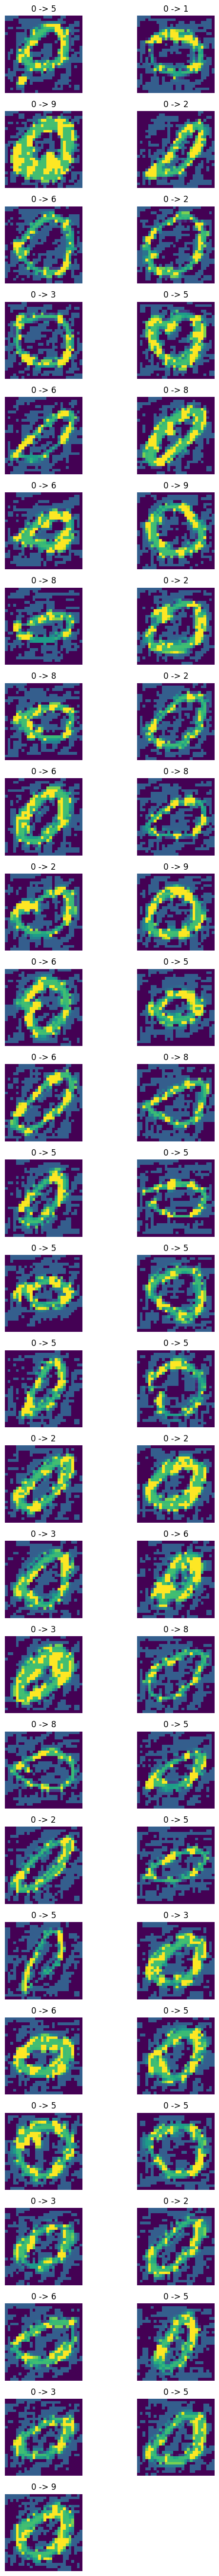

In [ ]:
adv_misclassified_images, adv_misclassified_labels, adv_misclassified_preds = analyze_for_misclassifications(misclassified_images, misclassified_labels, misclassified_preds)

In [ ]:
# Generate adversarial dataset
import torch
import tqdm
from torch.utils.data import DataLoader, TensorDataset

def generate_adversarial_dataset(model, attack, data_loader, device, num_samples):
    adv_data = []
    adv_labels = []
    device = next(model.parameters()).device

    num_generated = 0
    progress_bar = tqdm.tqdm(total=num_samples, unit='sample', desc='Adversarial Attack')

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        y = y.long()

        x_adv = attack(x, y)

        with torch.no_grad():
            orig_preds = model(x).argmax(1)
            adv_preds = model(x_adv).argmax(1)

        # Filter samples where original prediction is different from adversarial prediction
        mask = orig_preds != adv_preds
        x_adv_filtered = x_adv[mask]
        y_filtered = y[mask]

        # Append only the required number of samples
        num_remaining = num_samples - num_generated
        if num_remaining > 0:
            if num_remaining >= len(x_adv_filtered):
                adv_data.append(x_adv_filtered.detach())
                adv_labels.append(y_filtered.detach())
                num_generated += len(x_adv_filtered)
                progress_bar.update(len(x_adv_filtered))
            else:
                adv_data.append(x_adv_filtered[:num_remaining].detach())
                adv_labels.append(y_filtered[:num_remaining].detach())
                num_generated = num_samples
                progress_bar.update(num_remaining)
                break

        if num_generated >= num_samples:
            break

    progress_bar.close()

    if len(adv_data) > 0:
        adv_data = torch.cat(adv_data)
        adv_labels = torch.cat(adv_labels)

        if device != torch.device('cpu'):
            adv_data = adv_data.to('cpu')
            adv_labels = adv_labels.to('cpu')

        adv_dataset = TensorDataset(adv_data, adv_labels)

        if num_generated < num_samples:
            print(f"Warning: Could not generate {num_samples} unique adversarial examples.")
            print(f"Returning {num_generated} unique adversarial examples.")
    else:
        adv_dataset = None
        print("Warning: No unique adversarial examples found.")

    return adv_dataset

In [ ]:
print(len(filtered_train_loader))
adv_dataset = generate_adversarial_dataset(model, attack, filtered_train_loader, device, 60)

3750


Adversarial Attack: 100%|██████████| 60/60 [00:00<00:00, 1211.74sample/s]


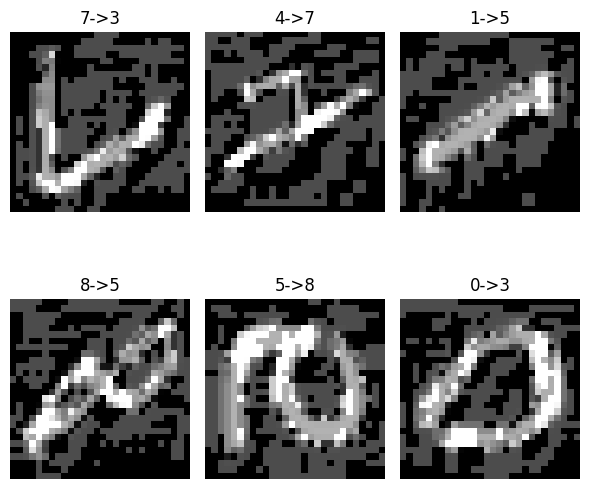

In [ ]:
# Print adversarial images
adv_loader = DataLoader(adv_dataset, batch_size=len(adv_dataset))
images, labels = next(iter(adv_loader))

# Move the input tensors to the same device as the model
device = next(model.parameters()).device
images = images.to(device)

preds = model(images)

fig = plt.figure(figsize=(6, 6))
for i in range(6):
    ax = fig.add_subplot(2, 3, i+1)
    img = images[i].cpu().squeeze()  # Move the image back to CPU for visualization
    ax.imshow(img, cmap='gray')
    orig = labels[i].item()
    pred = preds[i].argmax().item()
    ax.set_title(f"{orig}->{pred}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Adversarial training
# Create adversarial dataset
adv_loader = DataLoader(adv_dataset, batch_size=len(adv_dataset))

images, labels = next(iter(adv_loader))

adv_ds = TensorDataset(images, labels)

print(len(adv_ds))

60


In [ ]:
# Adversarial dataset
adv_loader = DataLoader(adv_dataset, batch_size=len(adv_dataset))
adv_images, adv_labels = next(iter(adv_loader))
adv_ds = TensorDataset(adv_images, adv_labels)

# Filtered training set
images, labels = next(iter(filtered_train_loader))
clean_ds = TensorDataset(images, labels)
clean_loader = DataLoader(clean_ds, batch_size=len(clean_ds))

# Combine into one dataset
combined_tensors = (torch.cat((adv_images, images)),
                    torch.cat((adv_labels, labels)))

combined_tensor_dataset = TensorDataset(*combined_tensors)

# Create combined data loader
combineloader = DataLoader(combined_tensor_dataset, batch_size=128,
                           shuffle=True, num_workers=4)

In [ ]:
for clean_images, clean_targets in clean_loader:
    num_clean_elements = len(clean_images)
    print(f"Number of clean images: {num_clean_elements}")

for adv_images, adv_targets in adv_loader:
    num_adv_elements = len(adv_images)
    print(f"Number of adversarial images: {num_adv_elements}")

for combined_images, combined_targets in combineloader:
    num_combined_elements = len(combined_images)
    print(f"Number of combined images: {num_combined_elements}")

Number of clean images: 64
Number of adversarial images: 60
Number of combined images: 124


In [ ]:
def save_retrained_model(model, save_dir):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    model_path = f"{save_dir}/retrained_model.pth"

    torch.save(model.state_dict(), model_path)
    #print(f"Saved retrained_model state dict to {model_path}")

In [ ]:
def adversarial_retraining(model, combined_loader, optimizer, loss_fn, num_epochs, device):
    adv_trained_dataset = []
    adv_images = []
    adv_labels = []

    # Model folder
    save_dir = 'retrained_models'
    max_images = 124

    model.to(device)  # Move the model to the specified device

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        for i, (imgs, labels) in enumerate(combined_loader):
            if len(adv_images) == max_images:
                break

            imgs, labels = imgs.to(device), labels.to(device)  # Move input data to the specified device

            preds = model(imgs)
            loss = loss_fn(preds, labels)

            # Adversarial training step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print images
            if i == 0:
                print_images(imgs.cpu(), labels.cpu(), preds.cpu(), n=3)  # Move data back to CPU for printing

            adv_images.append(imgs.detach().cpu()[:max_images-len(adv_images)])  # Move data back to CPU
            adv_labels.append(labels.detach().cpu()[:max_images-len(adv_labels)])  # Move data back to CPU

    adv_images = torch.cat(adv_images)[:max_images]
    adv_labels = torch.cat(adv_labels)[:max_images]

    # Create TensorDataset
    adv_dataset = TensorDataset(adv_images, adv_labels)
    print(f"Number of images: {len(adv_dataset)}")

    save_retrained_model(model, save_dir)

    return adv_dataset

Epoch 1/10


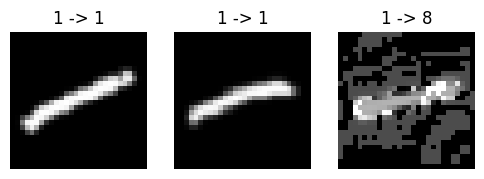

Epoch 2/10


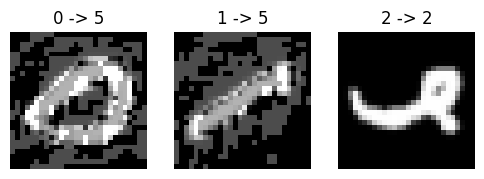

Epoch 3/10


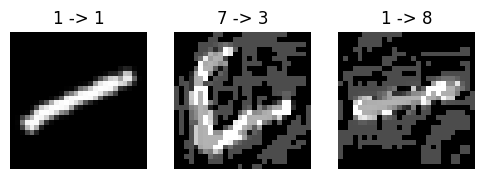

Epoch 4/10


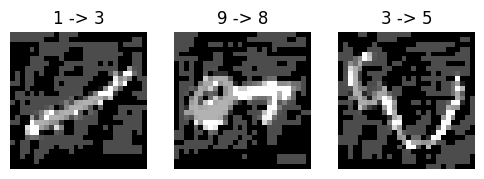

Epoch 5/10


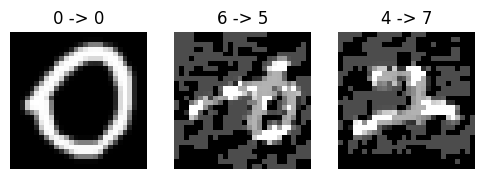

Epoch 6/10


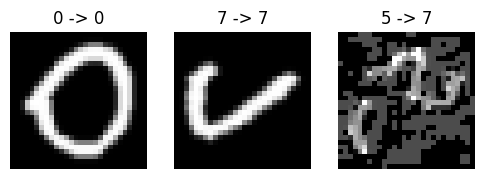

Epoch 7/10


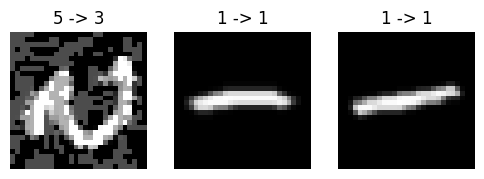

Epoch 8/10


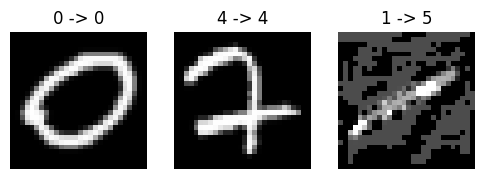

Epoch 9/10


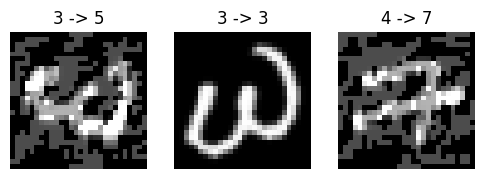

Epoch 10/10


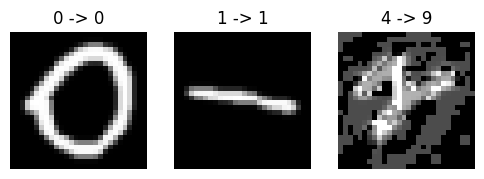

Number of images: 124


In [ ]:
# Start the timer
start_time_retrain = time.time()
adv_trained_dataset = adversarial_retraining(clean_model, combineloader, optimizer, loss_fn, num_epochs, device)
# End the timer
end_time_retrain = time.time()

In [ ]:
# Print the training duration in different units

# Calculate the training duration
retraining_duration_seconds = abs(end_time_retrain - start_time_retrain)

# Calculate the training duration in minutes
retraining_duration_minutes = retraining_duration_seconds / 60

# Calculate the training duration in hours
retraining_duration_hours = retraining_duration_minutes / 60

print(f"Training duration: {retraining_duration_seconds:.2f} seconds")
print(f"Training duration: {retraining_duration_minutes:.2f} minutes")
print(f"Training duration: {retraining_duration_hours:.2f} hours")

Training duration: 5.93 seconds
Training duration: 0.10 minutes
Training duration: 0.00 hours


In [ ]:
for clean_images, clean_targets in clean_loader:
    num_clean_elements = len(clean_images)
    print(f"Number of clean images: {num_clean_elements}")

for adv_images, adv_targets in adv_loader:
    num_adv_elements = len(adv_images)
    print(f"Number of adversarial images: {num_adv_elements}")

for combined_images, combined_targets in combineloader:
    num_combined_elements = len(combined_images)
    print(f"Number of combined images: {num_combined_elements}")

adv_trained_images_tensor, adv_trained_labels_tensor = adv_trained_dataset.tensors
num_adv_trained_elements = len(adv_trained_images_tensor)
print(f"Number of adversarially trained images: {num_adv_trained_elements}")

Number of clean images: 64
Number of adversarial images: 60
Number of combined images: 124
Number of adversarially trained images: 124


In [ ]:
def load_retrained_model(model, save_dir):
    # Model folder
    model_path = f"{save_dir}/retrained_model.pth"

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found in {model_path}")

    model.load_state_dict(torch.load(model_path))
    model.eval()

    print(f"Loaded retrained_model state dict from {model_path}")
    return model

In [ ]:
def evaluate_after_adv_retraining(model, data_loader, loss_fn, device):
    after_adv_test_loss = 0
    after_adv_accuracy = 0
    num_misclassified = 0
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    # Create dataset
    dataset_size = len(data_loader.dataset)
    print(f"Number of adv. retrained test images: {dataset_size}")

    with torch.no_grad():
        for i, (x, y) in enumerate(data_loader):
            x, y = x.to(device), y.to(device)  # Move input data to the specified device
            logits = model(x)
            batch_loss = loss_fn(logits, y)
            after_adv_test_loss += batch_loss.item()
            preds = torch.argmax(logits, dim=1)
            after_adv_accuracy += torch.sum(preds == y).item() / len(y)
            incorrect_inds = torch.where(preds != y)[0]
            num_misclassified += len(incorrect_inds)

            # Filter indices to current batch size
            incorrect_inds = incorrect_inds[incorrect_inds < len(x)]

            if len(incorrect_inds) > 0:
                misclassified_images.append(x[incorrect_inds].cpu())  # Move data back to CPU
                misclassified_labels.append(y[incorrect_inds].cpu())  # Move data back to CPU
                misclassified_preds.append(preds[incorrect_inds].cpu())  # Move data back to CPU

    num_misclassified = min(num_misclassified, dataset_size)
    print(f"Number of misclassified images: {num_misclassified} out of {dataset_size}")

    after_adv_test_loss /= len(data_loader)
    after_adv_accuracy /= len(data_loader)
    print(f"Adversarial Retrained Test loss: {after_adv_test_loss:.4f}, Accuracy: {after_adv_accuracy:.2%}")

    # Handle empty lists
    if len(misclassified_images) == 0:
        misclassified_images.append(torch.tensor([]))
    if len(misclassified_labels) == 0:
        misclassified_labels.append(torch.tensor([]))
    if len(misclassified_preds) == 0:
        misclassified_preds.append(torch.tensor([]))

    return after_adv_test_loss, after_adv_accuracy, [torch.cat(misclassified_images)], [torch.cat(misclassified_labels)], [torch.cat(misclassified_preds)]

In [ ]:
# Model folder
save_dir = 'retrained_models'

# Loading
retrained_model = load_retrained_model(CNN().to(device), save_dir)

Loaded retrained_model state dict from retrained_models/retrained_model.pth


In [ ]:
# Create dataset and loader
adv_retrain_loader = DataLoader(adv_trained_dataset, batch_size=124, shuffle=False)
adv_retrain_test_loss, adv_retrain_test_acc, misclassified_images, misclassified_labels, misclassified_preds = evaluate_after_adv_retraining(retrained_model, adv_retrain_loader, loss_fn, device)

Number of adv. retrained test images: 124
Number of misclassified images: 60 out of 124
Adversarial Retrained Test loss: 2.3948, Accuracy: 51.61%


Number misclassified: 60


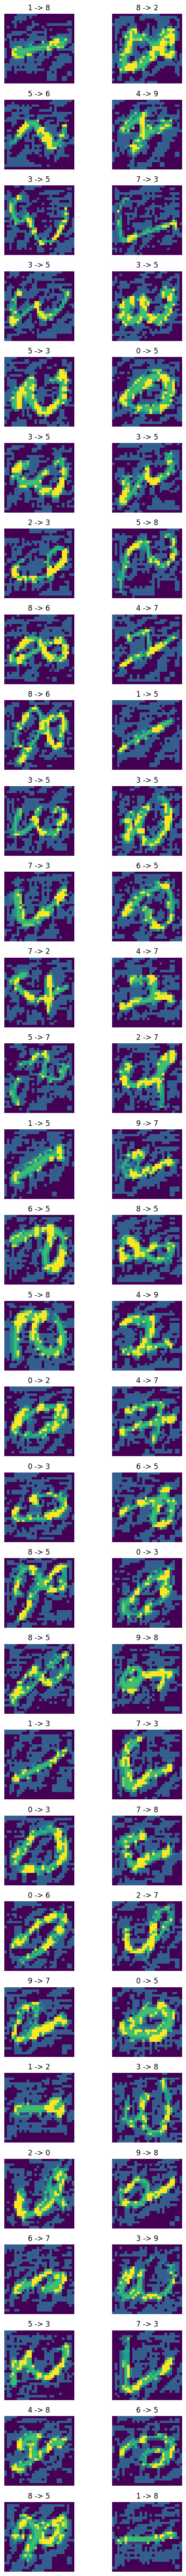

(tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.3000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.3000, 0.0000, 0.0000],
           [0.0000, 0.3000, 0.3000,  ..., 0.3000, 0.3000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.3000,  ..., 0.0000, 0.0000, 0.0000],
           [0.3000, 0.0000, 0.3000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.3000, 0.3000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000

In [ ]:
analyze_for_misclassifications(misclassified_images, misclassified_labels, misclassified_preds)

In [ ]:
import torch
import tqdm
from torch.utils.data import DataLoader, TensorDataset

def perform_adv_attack_after_retraining(model, attack, data_loader, device):
    adv_data = []
    adv_labels = []
    device = next(model.parameters()).device

    total_batches = len(data_loader)
    progress_bar = tqdm.tqdm(total=total_batches, unit='batch', desc='Adversarial Attack')

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)

        # Convert labels to long data type
        y = y.long()

        x_adv = attack(x, y)
        adv_data.append(x_adv.detach())
        adv_labels.append(y.detach())

        progress_bar.update(1)

    progress_bar.close()

    adv_data = torch.cat(adv_data)
    adv_labels = torch.cat(adv_labels)

    # Move data back to CPU if necessary
    if device != torch.device('cpu'):
        adv_data = adv_data.to('cpu')
        adv_labels = adv_labels.to('cpu')

    # Create dataset and loader
    adv_dataset = TensorDataset(adv_data, adv_labels)
    adv_loader = DataLoader(adv_dataset, batch_size=64, shuffle=False)

    return adv_dataset

In [ ]:
# Adversarial attack on retrained model
#adv_retrain_loader = perform_adv_attack_after_retraining(retrained_model, attack, filtered_test_loader, device)
adv_retrain_loader = perform_adv_attack(model, attack, filtered_test_loader)

Adversarial Attack: 100%|██████████| 625/625 [00:08<00:00, 71.81batch/s]


In [ ]:
def evaluate_adv_attack_after_retraining(model, data_loader, loss_fn, device):
    atack_after_retrained_test_loss = 0
    atack_after_retrained_accuracy = 0
    num_misclassified = 0
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)  # Move data to the specified device
    num_clean_test_elements = len(images)
    print(f"Number of clean test images: {num_clean_test_elements}")

    # Create dataset
    test_ds = TensorDataset(images, labels)
    # Create loader
    test_loader = DataLoader(test_ds, batch_size=64)
    dataset_size = len(test_loader.dataset)

    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)  # Move data to the specified device
            logits = model(x)
            batch_loss = loss_fn(logits, y)
            atack_after_retrained_test_loss += batch_loss.item()
            preds = torch.argmax(logits, dim=1)
            atack_after_retrained_accuracy += torch.sum(preds == y).item() / len(y)
            incorrect_inds = torch.where(preds != y)[0]
            num_misclassified += len(incorrect_inds)

            # Filter indices to current batch size
            incorrect_inds = incorrect_inds[incorrect_inds < len(x)]

            if len(incorrect_inds) > 0:
                misclassified_images.append(x[incorrect_inds].cpu())  # Move data back to CPU
                misclassified_labels.append(y[incorrect_inds].cpu())  # Move data back to CPU
                misclassified_preds.append(preds[incorrect_inds].cpu())  # Move data back to CPU

    num_misclassified = min(num_misclassified, dataset_size)
    print(f"Number of misclassified images: {num_misclassified} out of {dataset_size}")
    atack_after_retrained_test_loss /= len(test_loader)
    atack_after_retrained_accuracy /= len(test_loader)
    print(f"Adv. Attack Against Retrained Test loss: {atack_after_retrained_test_loss:.4f}, Accuracy: {atack_after_retrained_accuracy:.2%}")

    # Handle empty lists
    if len(misclassified_images) == 0:
        misclassified_images.append(torch.tensor([]))
    if len(misclassified_labels) == 0:
        misclassified_labels.append(torch.tensor([]))
    if len(misclassified_preds) == 0:
        misclassified_preds.append(torch.tensor([]))

    return atack_after_retrained_test_loss, atack_after_retrained_accuracy, [torch.cat(misclassified_images)], [torch.cat(misclassified_labels)], [torch.cat(misclassified_preds)]

In [ ]:
# Evaluate attack after retraining
retrained_test_loss, retrained_accuracy, misclassified_images, misclassified_labels, misclassified_preds = evaluate_adv_attack_after_retraining(retrained_model, filtered_test_loader, loss_fn, device)
print("\nA few key ways to evaluate whether an adversarial attack on a machine learning model was successful:\n")
print("Drop in Model Accuracy: 20-40% drop in accuracy indicates the attack was effective.\n")
print("High Loss Value: A sharp spike in loss is another sign of a working attack.\n")
print("Misclassified Examplese: Images wrongly labeled indicates a successful targeted attack\n")

Number of clean test images: 64
Number of misclassified images: 0 out of 64
Adv. Attack Against Retrained Test loss: 0.0014, Accuracy: 100.00%

A few key ways to evaluate whether an adversarial attack on a machine learning model was successful:

Drop in Model Accuracy: 20-40% drop in accuracy indicates the attack was effective.

High Loss Value: A sharp spike in loss is another sign of a working attack.

Misclassified Examplese: Images wrongly labeled indicates a successful targeted attack



In [ ]:
retrained_misclassified_images, retrained_misclassified_labels, retrained_misclassified_preds = analyze_for_misclassifications(misclassified_images, misclassified_labels, misclassified_preds)

Number misclassified: 0


<Figure size 600x0 with 0 Axes>

In [ ]:
def precision(true_positives, false_positives):
    if true_positives + false_positives == 0:
        return 0.0
    return true_positives / (true_positives + false_positives)

In [ ]:
def recall(true_positives, false_negatives):
    if true_positives + false_negatives == 0:
        return 0.0
    return true_positives / (true_positives + false_negatives)

In [ ]:
def f1_score(precision, recall):
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

In [ ]:
from sklearn.metrics import roc_auc_score

def auc_score(true_labels, predicted_probabilities):
    if len(set(true_labels)) == 2:
        return roc_auc_score(true_labels, predicted_probabilities)
    else:
        return "ROC AUC score is not defined for a single class."

In [ ]:
def print_summary_images(images, labels, preds, stage, attack_name, dataset_name, num_clean_elements, num_adv_elements, num_combined_elements, num_epoch, num_test_images):
    # Check for no images
    if len(images) == 0:
        print(f"\n---------------------------------------------------------")
        print(f"No misclassified images for stage: {stage}")
        print(f"Attack: {attack_name}")
        print(f"Dataset: {dataset_name}")
        print(f"Training Epochs: {num_epoch}")
        if stage == "Clean":
            print(f"Trained Clean Images: {num_clean_elements}")
            accuracy = test_acc
        elif stage == "No Defense Attack":
            print(f"Adversarial Training Images: {num_adv_elements}")
            accuracy = clean_attack_adv_test_accuracy
        elif stage == "w/ Defense Attack":
            print(f"Retrained Clean and Adversarial Images: {num_combined_elements}")
            accuracy = retrained_accuracy
        print(f"Test Images: {num_test_images}")
        print(f"Accuracy: {accuracy:.2f}")

        true_positives = int(accuracy * num_test_images)
        false_positives = 0
        false_negatives = num_test_images - true_positives

        precision_value = precision(true_positives, false_positives)
        recall_value = recall(true_positives, false_negatives)
        f1_score_value = f1_score(precision_value, recall_value)

        # Create the true labels and predicted probabilities based on the variables
        true_labels = [1] * true_positives + [0] * false_negatives
        predicted_probabilities = [1] * true_positives + [0] * false_negatives
        auc = auc_score(true_labels, predicted_probabilities)

        print(f"Precision: {precision_value:.2f}")
        print(f"Recall: {recall_value:.2f}")
        print(f"F1-score: {f1_score_value:.2f}")
        if isinstance(auc, float):
            print(f"ROC AUC Score: {auc:.2f}")
        else:
            print(auc)
        print(f"---------------------------------------------------------\n")
    else:
        # Count the number of misclassifications for each situation
        misclassifications = {}
        for label, pred in zip(labels, preds):
            if label != pred:
                key = f"{label} -> {pred}"
                misclassifications[key] = misclassifications.get(key, 0) + 1

        # Plot images
        num_images = len(images)
        print(f"\n---------------------------------------------------------")
        print(f"Number of misclassified images for {stage}: {num_images}")
        print(f"Attack: {attack_name}")
        print(f"Dataset: {dataset_name}")
        print(f"Training Epochs: {num_epoch}")
        if stage == "Clean":
            print(f"Trained Clean Images: {num_clean_elements}")
            accuracy = test_acc
        elif stage == "No Defense Attack":
            print(f"Adversarial Training Images: {num_adv_elements}")
            accuracy = clean_attack_adv_test_accuracy
        elif stage == "w/ Defense Attack":
            print(f"Retrained Clean and Adversarial Images: {num_combined_elements}")
            accuracy = retrained_accuracy
        print(f"Test Images: {num_test_images}")
        print(f"Accuracy: {accuracy:.2f}")

        true_positives = int(accuracy * num_test_images)
        false_positives = num_images
        false_negatives = num_test_images - true_positives - false_positives

        precision_value = precision(true_positives, false_positives)
        recall_value = recall(true_positives, false_negatives)
        f1_score_value = f1_score(precision_value, recall_value)

        # Create the true labels and predicted probabilities based on the variables
        true_labels = [1] * true_positives + [0] * false_negatives
        predicted_probabilities = [1] * true_positives + [0] * false_negatives
        auc = auc_score(true_labels, predicted_probabilities)

        print(f"Precision: {precision_value:.2f}")
        print(f"Recall: {recall_value:.2f}")
        print(f"F1-score: {f1_score_value:.2f}")
        if isinstance(auc, float):
            print(f"ROC AUC Score: {auc:.2f}")
        else:
            print(auc)
        print(f"---------------------------------------------------------\n")

        fig = plt.figure(figsize=(6, num_images))
        rows = math.ceil(num_images / 2)
        cols = 2 if num_images > 16 else min(num_images, 2)
        for i, (img, label, pred) in enumerate(zip(images, labels, preds)):
            # Add subplot
            ax = fig.add_subplot(rows, cols, i+1)
            # Add empty dim if needed
            if img.ndim == 2:
                img = img[:,None,:,]
            # Permute to HWC format for imshow
            img = img.permute(1, 2, 0)
            ax.imshow(img)
            ax.set_title(f"{label} -> {pred}")
            ax.axis("off")

        # Print the number of misclassifications for each situation
        print("Misclassifications:")
        for situation, count in misclassifications.items():
            print(f"{situation}: {count}")

        plt.tight_layout()
        plt.show()

In [ ]:
for clean_images, clean_labels in clean_loader:
    num_clean_elements = len(clean_images)
    print(f"Number of clean images: {num_clean_elements}")

for adv_images, adv_labels in adv_loader:
    num_adv_elements = len(adv_images)
    print(f"Number of adversarial images: {num_adv_elements}")

for combined_images, combined_labels in combineloader:
    num_combined_elements = len(combined_images)
    print(f"Number of combined images: {num_combined_elements}")

adv_trained_images_tensor, adv_trained_labels_tensor = adv_trained_dataset.tensors
num_adv_trained_elements = len(adv_trained_images_tensor)
print(f"Number of adversarially trained images: {num_adv_trained_elements}")

Number of clean images: 64
Number of adversarial images: 60
Number of combined images: 124
Number of adversarially trained images: 124


In [ ]:
import tabulate

In [ ]:
def summarize_performance(clean_loss, clean_acc, adv_loss, adv_acc, retrain_loss, retrain_acc,
                          clean_misclassified_images, adv_misclassified_images, retrained_misclassified_images,
                          clean_misclassified_labels, adv_misclassified_labels, retrained_misclassified_labels,
                          clean_misclassified_preds,adv_misclassified_preds, retrained_misclassified_preds):

    table_data = [["Metric", "Clean", "No Defense Attack", "w/ Defense Attack"],
                  ["Loss", f'{clean_loss:.3g}', f'{adv_loss:.3g}', f'{retrain_loss:.3g}'],
                  ["Accuracy", f'{clean_acc:.0%}', f'{adv_acc:.0%}', f'{retrain_acc:.0%}']]

    print(tabulate.tabulate(table_data, headers="firstrow", tablefmt="grid"))

    print("\nExample Misclassifications:")
    print_summary_images(clean_misclassified_images, clean_misclassified_labels, clean_misclassified_preds, "Clean", compounded_attack_name, dataset_name, num_clean_elements, num_adv_elements, num_combined_elements, num_epochs, len(filtered_test_loader))
    print_summary_images(adv_misclassified_images, adv_misclassified_labels, adv_misclassified_preds, "No Defense Attack",  compounded_attack_name, dataset_name, num_clean_elements, num_adv_elements, num_combined_elements, num_epochs, len(filtered_test_loader))
    print_summary_images(retrained_misclassified_images, retrained_misclassified_labels, retrained_misclassified_preds, "w/ Defense Attack",  compounded_attack_name, dataset_name, num_clean_elements, num_adv_elements, num_combined_elements, num_epochs, len(filtered_test_loader))

+----------+---------+---------------------+---------------------+
| Metric   | Clean   | No Defense Attack   | w/ Defense Attack   |
+==========+=========+=====================+=====================+
| Loss     | 0.00142 | 3.43                | 0.00142             |
+----------+---------+---------------------+---------------------+
| Accuracy | 100%    | 17%                 | 100%                |
+----------+---------+---------------------+---------------------+

Example Misclassifications:

---------------------------------------------------------
No misclassified images for stage: Clean
Attack: fgsm_pgd_attack
Dataset: EMNIST
Training Epochs: 10
Trained Clean Images: 64
Test Images: 625
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00
ROC AUC score is not defined for a single class.
---------------------------------------------------------


---------------------------------------------------------
Number of misclassified images for No Defense Attack: 53
Attack: fgsm_pgd_

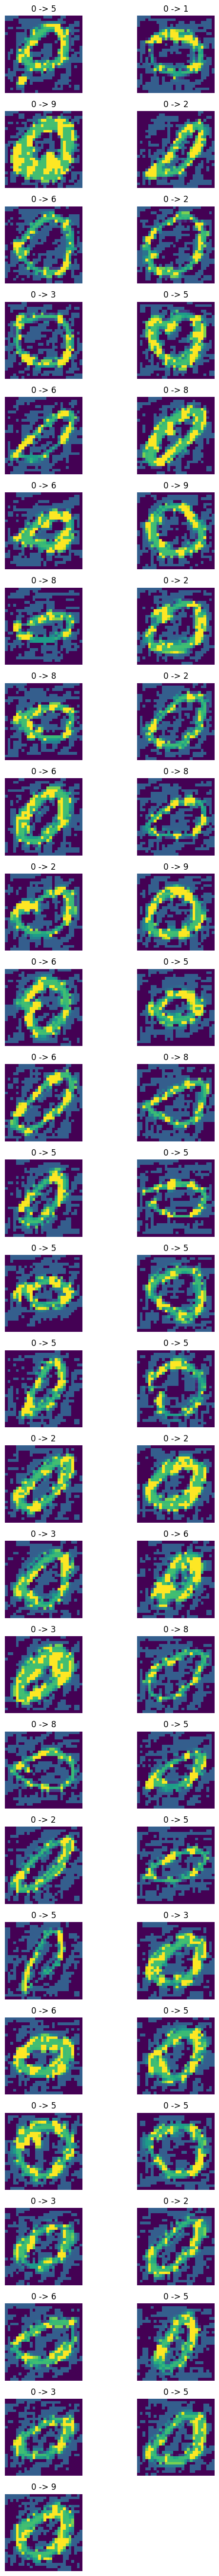


---------------------------------------------------------
No misclassified images for stage: w/ Defense Attack
Attack: fgsm_pgd_attack
Dataset: EMNIST
Training Epochs: 10
Retrained Clean and Adversarial Images: 124
Test Images: 625
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00
ROC AUC score is not defined for a single class.
---------------------------------------------------------



In [ ]:
summarize_performance(test_loss, test_acc, clean_attack_test_loss, clean_attack_adv_test_accuracy, retrained_test_loss, retrained_accuracy,
                          clean_misclassified_images, adv_misclassified_images, retrained_misclassified_images,
                          clean_misclassified_labels, adv_misclassified_labels, retrained_misclassified_labels,
                          clean_misclassified_preds,adv_misclassified_preds, retrained_misclassified_preds)